# CS235 Midterm Report
### Neural Network | Ryan Chandler

### Importing required packages

In [131]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

import matplotlib.pyplot as plt
import plotly.express as px

In [132]:
df = pd.read_csv('amazon_data.csv')
df = df.drop('title', axis=1)
df = df.drop('Unnamed: 0', axis=1)

df.head()

,stars,reviews,price,listPrice,category,isBestSeller,boughtInLastMonth
0,4.5,0,139.99,0.00,Suitcases,False,2000
1,4.5,0,169.99,209.99,Suitcases,False,1000
2,4.6,0,365.49,429.99,Suitcases,False,300
3,4.6,0,291.59,354.37,Suitcases,False,400
4,4.5,0,174.99,309.99,Suitcases,False,400


### Z-Score Standardization

In [133]:
df['reviews'] = (df['reviews'] - df['reviews'].mean()) / df['reviews'].std()
df['stars'] = (df['stars'] - df['stars'].mean()) / df['stars'].std()
df['price'] = (df['price'] - df['price'].mean()) / df['price'].std()
df['listPrice'] = (df['listPrice'] - df['listPrice'].mean()) / df['listPrice'].std()
df['boughtInLastMonth'] = (df['boughtInLastMonth'] - df['boughtInLastMonth'].mean()) / df['boughtInLastMonth'].std()

df.head()

,stars,reviews,price,listPrice,category,isBestSeller,boughtInLastMonth
0,0.372306,-0.102615,0.741539,-0.269977,Suitcases,False,2.221786
1,0.372306,-0.102615,0.971796,4.283937,Suitcases,False,1.026003
2,0.446695,-0.102615,2.472303,9.054931,Suitcases,False,0.188955
3,0.446695,-0.102615,1.905104,7.415010,Suitcases,False,0.308533
4,0.372306,-0.102615,1.010172,6.452571,Suitcases,False,0.308533


### One-Hot Encoding

In [134]:
oh_df = pd.get_dummies(df, columns=['category']) # One-hot encoding on categories data
oh_df = oh_df.astype({col: int for col in oh_df.columns if 'category_' in col}) #

#df -> dataset w/o one-hot encoding
df = df.drop('category', axis=1)
oh_df.head()


### Upsampling

In [135]:
maj_df = oh_df[oh_df['isBestSeller'] == False]
min_df = oh_df[oh_df['isBestSeller'] == True]

maj_df = maj_df.sample(n=25560)
sampled_df = pd.concat([maj_df, min_df])

#upsample = resample(min_df, replace=True,n_samples=1417817)
#sampled_df = pd.concat([maj_df, upsample])

sampled_df = sampled_df.sample(frac=1) #randomly sorts it
print(sampled_df['isBestSeller'].value_counts())
sampled_df

isBestSeller
False    25560
True      8520
Name: count, dtype: int64


,stars,reviews,price,listPrice,isBestSeller,boughtInLastMonth,category_Abrasive & Finishing Products,category_Accessories & Supplies,category_Additive Manufacturing Products,category_Arts & Crafts Supplies,...,category_Women's Accessories,category_Women's Clothing,category_Women's Handbags,category_Women's Jewelry,category_Women's Shoes,category_Women's Watches,"category_Xbox 360 Games, Consoles & Accessories","category_Xbox One Games, Consoles & Accessories","category_Xbox Series X & S Consoles, Games & Accessories",category_eBook Readers & Accessories
1244726,0.595472,-0.102615,-0.129830,-0.269977,False,-0.169780,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
273365,0.521083,-0.100344,-0.225540,-0.269977,False,-0.169780,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1396259,0.744249,-0.102615,-0.010633,-0.269977,False,-0.169780,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
309341,0.744249,-0.099208,-0.271591,-0.269977,False,-0.050202,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
520242,-0.669134,-0.102615,-0.218709,0.380613,False,1.026003,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589652,-1.115466,-0.102615,-0.025984,0.705692,False,-0.169780,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
113859,-2.975180,-0.102615,1.712916,-0.269977,False,-0.169780,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1311384,0.074752,-0.102615,-0.029054,-0.269977,False,-0.169780,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1264753,-2.975180,-0.102615,0.050769,1.247850,True,-0.169780,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Neural Network

### Importing required libraries

In [136]:
import torch.nn as nn
import torch.nn.functional as F
import torch


from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

tensor([1.], device='mps:0')


### Preparing the dataloader

In [137]:
X = sampled_df.drop('isBestSeller', axis=1).values
y = sampled_df['isBestSeller'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True) #larger is faster, but maybe more generalized?
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

### Initializing the Model

In [138]:
class Model(nn.Module) :
    #input layer --> hidden layer (# of neurons) -> output
    def __init__(self, X, neurons, hidden_layers) :
        super(Model, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], neurons)
        fcarray = []
        for k in range(hidden_layers) :
            fcarray.append(nn.Linear(neurons//(2**(k)), neurons//(2**(k+1))))
        self.fcarray = fcarray
        self.out = nn.Linear(neurons//(2**hidden_layers),1)
    def forward(self, x) :
        x = F.relu(self.fc1(x))
        for layer in self.fcarray :
            x = F.relu(layer(x))
        x = F.sigmoid(self.out(x))
        return x

### Training the Regular Model

In [143]:
model = Model(X_train, 8, 1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
losses = []
for epoch in range(num_epochs) :
    for inputs, labels in train_loader :
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1, 1)
        loss = criterion(outputs, labels)           
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/100, Loss: 0.6027690172195435
Epoch 2/100, Loss: 0.5780974626541138
Epoch 3/100, Loss: 0.48318374156951904
Epoch 4/100, Loss: 0.42588749527931213
Epoch 5/100, Loss: 1.9437295198440552
Epoch 6/100, Loss: 0.4658655822277069
Epoch 7/100, Loss: 0.2591341435909271
Epoch 8/100, Loss: 0.40582069754600525
Epoch 9/100, Loss: 0.37960395216941833
Epoch 10/100, Loss: 0.3936017155647278
Epoch 11/100, Loss: 0.2590853273868561
Epoch 12/100, Loss: 0.3281189799308777
Epoch 13/100, Loss: 0.2918283939361572
Epoch 14/100, Loss: 1.7795960903167725
Epoch 15/100, Loss: 0.2234698235988617
Epoch 16/100, Loss: 0.29985564947128296
Epoch 17/100, Loss: 0.40993204712867737
Epoch 18/100, Loss: 0.4225160777568817
Epoch 19/100, Loss: 0.25257641077041626
Epoch 20/100, Loss: 0.22596673667430878
Epoch 21/100, Loss: 0.26597851514816284
Epoch 22/100, Loss: 0.18423660099506378
Epoch 23/100, Loss: 0.3873448967933655
Epoch 24/100, Loss: 0.24002158641815186
Epoch 25/100, Loss: 0.21688997745513916
Epoch 26/100, Loss: 0.

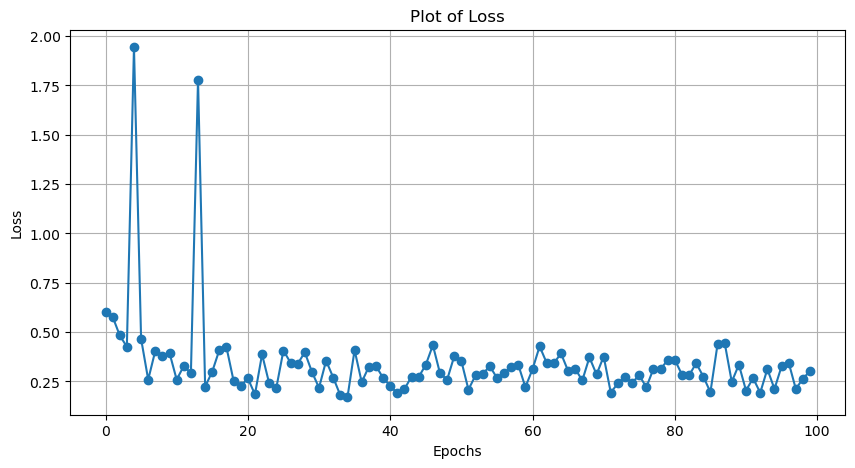

In [144]:
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o')
plt.title('Plot of Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True) 
plt.show()

### Evaluating the Model - Against Testing

In [147]:
from sklearn.metrics import confusion_matrix

model.eval()

with torch.no_grad():
    true_labels = []
    predicted_labels = []

    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.data > 0.5).int() 
        true_labels.extend(labels.int().tolist())
        predicted_labels.extend(predicted.tolist())

confusion = confusion_matrix(true_labels, predicted_labels)

tn, fp, fn, tp = confusion.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'Confusion Matrix:')
print(confusion)

Accuracy: 86.81%
Precision: 77.93%
Recall: 65.57%
Confusion Matrix:
[[4805  315]
 [ 584 1112]]
4805 315 584 1112


### Evaluating the Model - Against Training

In [146]:
model.eval()

with torch.no_grad():
    true_labels = []
    predicted_labels = []

    for inputs, labels in train_loader:
        outputs = model(inputs)
        predicted = (outputs.data > 0.5).int()
        true_labels.extend(labels.int().tolist())
        predicted_labels.extend(predicted.tolist())

confusion = confusion_matrix(true_labels, predicted_labels)

tn, fp, fn, tp = confusion.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'Confusion Matrix:')
print(confusion)

Accuracy: 87.53%
Precision: 80.00%
Recall: 66.88%
Confusion Matrix:
[[19299  1141]
 [ 2260  4564]]
